In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
#%matplotlib notebook
from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

Using TensorFlow backend.


In [2]:
n_nodes = 100
n_dofs = n_nodes*2
n_elements = n_nodes-1
x = np.linspace(0, 1, n_nodes)

In [3]:
L = 1000 #mm
rho = 0.006 #kg/mm
E = 210000 #N/mm2
I = 0.801*10**6 #mm4
A = 764 #mm^2

In [4]:
#Element stiffnes matrix
L = L/n_elements
k = np.matrix([[12, -6*L, -12, -6*L], [-6*L, 4*L**2, 6*L, 2*L**2], [-12, 6*L, 12, 6*L], [-6*L, 2*L**2, 6*L, 4*L**2]])*E*I/L**3

#Element mass matrix
m = np.matrix([[156, 22*L, 54, -13*L],[22*L, 4*L**2, 13*L, -3*L**2], [54, 13*L, 156, -22*L], [-13*L, -3*L**2, -22*L, 4*L**2]] )*rho*A*L/420

In [5]:
#Global stiffness matrix
n_dofs = n_nodes*2
K = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    K[2*i:2*i+4,2*i:2*i+4] += k
    
#Global mass matrix
M = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    M[2*i:2*i+4,2*i:2*i+4] += m
    

In [6]:
#Account for boundary conditions
K = K[2:,2:]

In [77]:
#Generate random loadvector
def get_loadvec():
    loadvec = 1000*(np.random.random(n_nodes)*2-1)

    #Force vector
    F = np.zeros(n_dofs) 
    F[0::2] = loadvec
    return F[2:]

In [78]:
n_cases = 10000

Kinv = inv(K)
Dz = np.zeros([n_cases, n_nodes])
F_mat = np.zeros([n_cases, n_nodes-1])
for i in range(n_cases):
    F = get_loadvec()
    d = np.matmul(Kinv, F)
    
    dz = d[0::2]
    dz = np.insert(dz, 0, 0)
    Dz[i, :] = dz
    F_mat[i, :] = F[0::2]

In [79]:
training_portion = 0.8
x_train = F_mat[0:int(n_cases*training_portion), :]*1/10000
y_train = Dz[0:int(n_cases*training_portion), :]
x_test = F_mat[int(n_cases*training_portion):, :]*1/10000
y_test = Dz[int(n_cases*training_portion):, :]

In [80]:
input_dim = n_nodes - 1
output_dim = n_nodes

def baseline_model():
    model = Sequential()
    height = 50
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    #model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(output_dim, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(x_train, y_train, epochs=50, verbose = 1)

Epoch 1/50
8000/8000 [==============================] - 1s 104us/step - loss: 2.9490
Epoch 2/50
8000/8000 [==============================] - 0s 55us/step - loss: 0.0916
Epoch 3/50
8000/8000 [==============================] - 1s 63us/step - loss: 0.0682
Epoch 4/50
8000/8000 [==============================] - 0s 56us/step - loss: 0.0531
Epoch 5/50
8000/8000 [==============================] - 0s 58us/step - loss: 0.0434
Epoch 6/50
8000/8000 [==============================] - 0s 54us/step - loss: 0.0369
Epoch 7/50
8000/8000 [==============================] - 0s 60us/step - loss: 0.0320
Epoch 8/50
8000/8000 [==============================] - 0s 56us/step - loss: 0.0288
Epoch 9/50
8000/8000 [==============================] - 0s 58us/step - loss: 0.0254
Epoch 10/50
8000/8000 [==============================] - 0s 56us/step - loss: 0.0229
Epoch 11/50
8000/8000 [==============================] - 0s 55us/step - loss: 0.0215
Epoch 12/50
8000/8000 [==============================] - 0s 61us/step - l

In [81]:
predictions = model.predict(x_test)

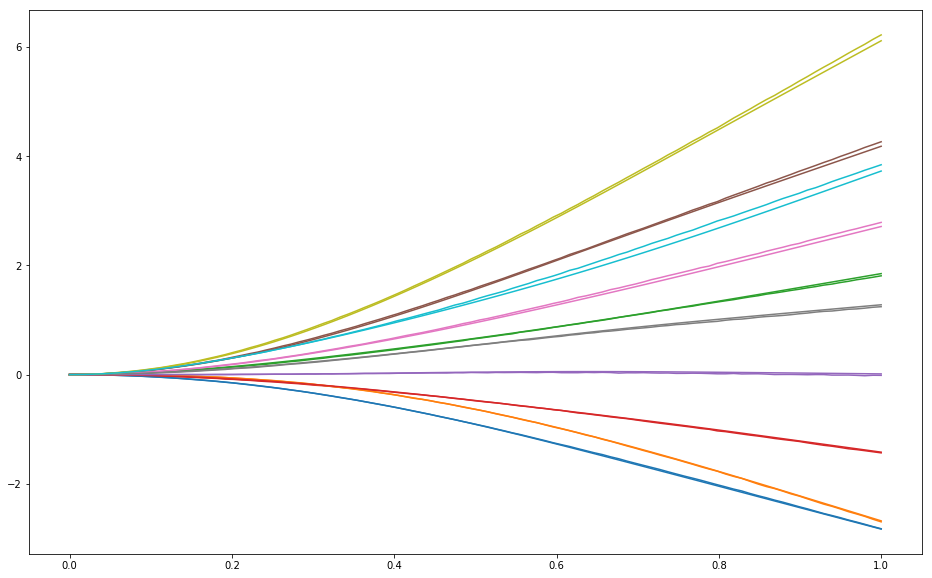

In [82]:
plt.figure(figsize=(16,10))

plt.plot(x, np.transpose(predictions[0:10,:]))
plt.plot(x, np.transpose(y_test[0:10,:]))

plt.show()

In [99]:
#Pointload
F = np.zeros(n_dofs-2)
F[-2] = -10000

#F= get_loadvec()

d = np.matmul(inv(K),F)
dz = d[0::2]
dz = np.insert(dz, 0, 0)

f = F[0::2]*1/10000
pred = model.predict(np.reshape(f,(1,len(f))))



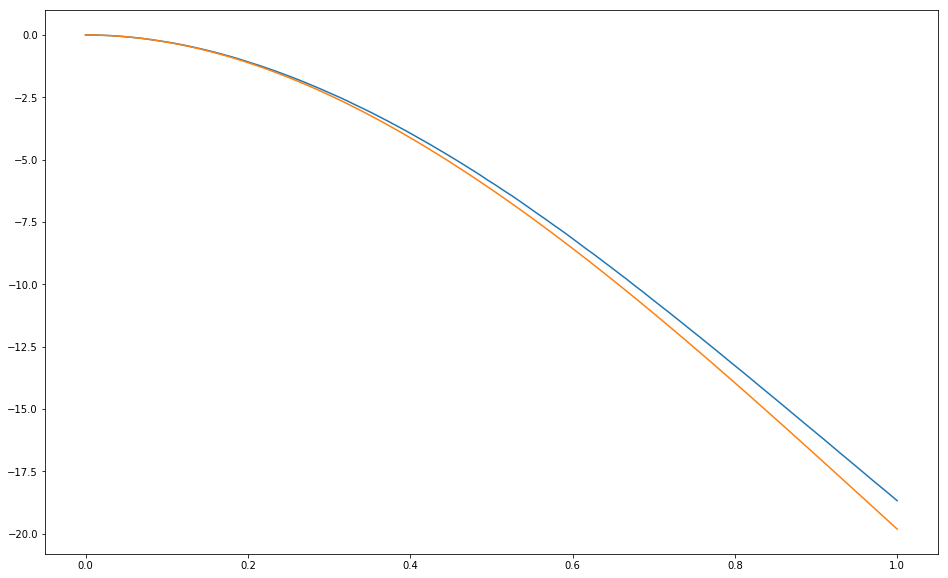

In [100]:
plt.figure(figsize=(16,10))

plt.plot(x, pred[0])
plt.plot(x, dz)

plt.show()